In [1]:
import numpy as np
import pandas as pd
import h5py
import pickle

import glob
import cooler

import time
from datetime import timedelta

import subprocess
import os
import itertools
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')

from copy import deepcopy as copy

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import lavaburst

def produce_segmentation(mtx, gamma, good_bins='default', method='modularity', max_intertad_size=3, max_tad_size=10000):
    """
    Produces single segmentation (TADs or CDs calling) of mtx with one gamma with the algorithm provided.
    :param mtx: input numpy matrix
    :param gamma: parameter for segmentation calling
    :param good_bins: bool vector with length of len(mtx) with False corresponding to masked bins, 'default' is that
        good bins are all columns/rows with sum > 0
    :param method: 'modularity' (default) or 'armatus'
    :param max_intertad_size: max size of segmentation unit that is considered as interTAD
    :return:  2D numpy array where segments[:,0] are segment starts and segments[:,1] are segments end, each row corresponding to one segment
    """
    if np.any(np.isnan(mtx)):
        logging.warning("NaNs in dataset, pease remove them first.")

    if np.diagonal(mtx).sum()>0:
        logging.warning("Note that diagonal is not removed. you might want to delete it to avoid noisy and not stable results. ")

    if method=='modularity':
        score = lavaburst.scoring.modularity_score
    elif method=='armatus':
        score = lavaburst.scoring.armatus_score
    else:
        pass

    if good_bins=='default':
        good_bins = mtx.astype(bool).sum(axis=0) > 0

    S = score(mtx, gamma=gamma, binmask=good_bins)
    model = lavaburst.model.SegModel(S)

    segments = model.optimal_segmentation()

    v = segments[:,1]-segments[:,0]
    mask = (v>max_intertad_size) & (np.isfinite(v)) & (v<max_tad_size)

    segments = segments[mask]

    return segments

In [79]:
files = glob.glob("../DATA/COOL/*.cool.10kb")
labels = ['_'.join(x.split('/')[-1].split('_')[0:-3]) for x in files]
resolution = 10000

In [80]:
labels

['nuclear_cycle_14',
 'mitotic_nuclear_cycle_1-14',
 'nuclear_cycle_12',
 'nuclear_cycle_14_alpha-amanitin_injected',
 '3-4h',
 'nuclear_cycle_14_water_injected',
 'nuclear_cycle_13',
 'nuclear_cycle_14_sh_zld',
 'nuclear_cycle_14_triptolide_injected']

In [81]:
datasets = {x:{} for x in labels}

In [82]:
balance = True

for label, file in zip(labels, files):
    c = cooler.Cooler(file)
    for ch in c.chromnames:
        mtx = c.matrix(balance=balance).fetch(ch)
        datasets[label][ch] = mtx.copy()

re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT X
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT X
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT 2L
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT 2L
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT 2R
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT 2R
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT 3L
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s*(?P<HYPHEN>-)')
INT 3L
re.compile('\\s*(?P<INT>[a-zA-z0-9_|]+)|\\s*(?P<ALNUM>[a-zA-z0-9_|]+)|\\s*(?P<COLON>:)|\\s

In [83]:
chrms = ['X', '2L', '2R', '3L', '3R']

In [90]:
df = pd.DataFrame(columns=['bgn','end','gamma', 'method', 'ch'])

gammas = np.arange(0, 5.0, 0.01)

for ch in chrms:
    
    print(ch)
    
    mtx = datasets['3-4h'][ch].copy()
    s = np.sum(mtx, axis=1)>1
    good_bins = s>0
    
    mtx[np.isnan(mtx)] = 0
    np.fill_diagonal(mtx, 0)
    mn = np.percentile(mtx[mtx>0], 1)
    mx = np.percentile(mtx[mtx>0], 99)
    mtx[mtx<=mn] = mn
    mtx[mtx>=mx] = mx
    mtx = np.log(mtx)
    mtx = mtx-np.min(mtx)
            
    for method in ['armatus']: #['modularity']:  #['armatus']: # 'modularity', #
        for gamma in gammas:
            segments = produce_segmentation(mtx, gamma, good_bins=good_bins, 
                                        method=method, max_intertad_size=2, max_tad_size=10000)
            df_tmp = pd.DataFrame(columns=['bgn','end','gamma','method'], index=np.arange(len(segments)))
            df_tmp.loc[:, ['bgn', 'end']] = segments
            df_tmp['gamma'] = gamma
            df_tmp['method'] = method
            df_tmp['ch'] = ch

            df = pd.concat([df, df_tmp])
            
df.loc[:,'gamma'] = df.gamma.values.astype(float)
df.loc[:,'bgn'] = df.bgn.values.astype(int)
df.loc[:,'end'] = df.end.values.astype(int)

df.loc[:, 'length'] = df.end-df.bgn

df.reset_index(drop=True, inplace=True)

X


/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2L
2R
3L
3R


In [91]:
df.to_csv("tads_armatus_10kb_0-5_0.01.csv", sep='\t')

In [93]:
expected1 = 120000/resolution
expected2 = 30000/resolution

In [94]:
print(1)

1


In [95]:
#koi = ["D_{}".format(exp) for exp in datasets.keys()] 

In [96]:
def get_D(mtx, segmentation):
    
    l = len(mtx)
    segments = np.concatenate( [np.array([[0,0]]), segmentation, np.array([[l,l]])] )
    
    Ds = []
    for i in range(1, len(segments)-1):
        p1, p2, p3, p4, p5, p6 = *segments[i-1, :], *segments[i, :], *segments[i+1, :]
        intra = np.nansum(mtx[:p3, p3:p4]) + np.nansum(mtx[p4:, p3:p4])
        inter = np.nansum(mtx[p3:p4, p3:p4])
        D = inter/intra
        Ds.append(D)
        
    return(Ds)

In [180]:
method = method #'modularity'

df_res = pd.DataFrame()

for ch in chrms:
    
    gr = df.query("ch=='{}'".format(ch)).reset_index(drop=True).groupby(['method', 'gamma']).mean().reset_index()
    
    #idx1 = np.argmin(np.abs(gr.length.values-expected1))
    idx2 = np.argmin(np.abs(gr.length.values-expected2))   
    idx = idx2
    
    opt_gamma = gr.loc[idx, 'gamma']
    df_tmp = df.query("ch=='{}'&method=='{}'&abs(gamma-{})<0.00005".format(ch, method, opt_gamma))
    segments = df_tmp[['bgn', 'end']].values

    for exp in datasets.keys():
        mtx_cor = datasets[exp][ch]
        np.fill_diagonal(mtx_cor, 0)

        Ds = get_D(mtx_cor, segments)
        df_tmp.loc[:, "D_{}".format(exp)] = Ds
    
    koi = [
        'D_mitotic_nuclear_cycle_1-14',
        'D_nuclear_cycle_12',
        'D_nuclear_cycle_13',
        'D_nuclear_cycle_14',
        'D_3-4h',
        'D_nuclear_cycle_14_sh_zld',
        'D_nuclear_cycle_14_water_injected',
        'D_nuclear_cycle_14_alpha-amanitin_injected',
        'D_nuclear_cycle_14_triptolide_injected'
    ]
    
    for x in koi:
        df_tmp.loc[:, 'z{}'.format(x)] = 0
    
    df_tmp.loc[:, ['z{}'.format(x) for x in koi]] = df_tmp.loc[:, koi].apply(scipy.stats.zscore, axis=1).values
    
    df_tmp.reset_index(drop=True)
    
    df_res = df_res.append(df_tmp, ignore_index=True)

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is adde

In [185]:
df_res = df_res.dropna(axis=0).reset_index(drop=True)

In [186]:
th = 5

exp = '3-4h'

filters = {}

for ch in chrms:
    
    mtx = datasets[exp][ch]

    v = np.where(np.nansum(mtx, axis=1)==0)[0]
    v_prev = v[0]
    v_tmp= [[0]]
    for i in range(1, len(v)-1):
        if v[i]-v_prev<th:
            v_prev = v[i]
        else:
            v_tmp[-1].append(v_prev)
            v_tmp.append([])
            v_tmp[-1].append(v[i])
            v_prev = v[i]

    v_tmp[-1].append(v_prev)
    v_tmp = np.array(v_tmp)

    filt = v_tmp[v_tmp[:,1]-v_tmp[:,0]>2]
    
    filters[ch] = filt.copy()

In [187]:
def determine_noisy(x):
    for bgn_f, end_f in filters[x.ch]:
        if x.bgn<=end_f and x.bgn>=bgn_f:
            return True
        if x.end<=end_f and x.end>=bgn_f:
            return True
    return False

df_res.loc[:, "noisy_region"] = df_res.apply(determine_noisy, axis=1)

In [188]:
#df_res.to_csv("../DATA/D_meanTAD30kb_10kb.csv")

In [313]:
df_res = pd.read_csv("../DATA/D_meanTAD120kb_10kb.csv")

In [318]:
df_res[[ 'bgn', 'end', 'gamma', 'method', 'ch', 'length', 'noisy_region',
       'D_nuclear_cycle_14', 
       'zD_nuclear_cycle_14', ]]

bgn   end  gamma   method  ch  length  noisy_region  D_nuclear_cycle_14  \
0      12    16   1.09  armatus   X       4          True            0.589946   
1      17    20   1.09  armatus   X       3          True            0.289652   
2      25    37   1.09  armatus   X      12         False            0.949144   
3      37    49   1.09  armatus   X      12         False            1.041194   
4      49    63   1.09  armatus   X      14         False            1.211297   
5      63    78   1.09  armatus   X      15         False            1.076323   
6      78   104   1.09  armatus   X      26         False            1.285621   
7     104   123   1.09  armatus   X      19         False            1.007837   
8     123   136   1.09  armatus   X      13         False            0.837727   
9     137   148   1.09  armatus   X      11         False            0.979175   
10    148   186   1.09  armatus   X      38         False            2.002033   
11    186   192   1.09  armatus   X       6         False            0.616290   
12    192   203   1.09  armatus   X      11         False            1.169383   
13    203   211   1.09  armatus   X       8         False            0.870218   
14    211   215   1.09  armatus   X       4         False            0.478205   
15    215   227   1.09  armatus   X      12         False            1.308972   
16    227   235   1.09  armatus   X       8         False            0.945432   
17    235   240   1.09  armatus   X       5         False            0.561897   
18    241   245   1.09  armatus   X       4         False            0.351034   
19    245   261   1.09  armatus   X      16         False            1.067706   
20    261   273   1.09  armatus   X      12         False            1.089339   
21    273   277   1.09  armatus   X       4         False            0.307075   
22    278   282   1.09  armatus   X       4         False            0.231954   
23    284   311   1.09  armatus   X      27         False            1.245697   
24    312   317   1.09  armatus   X       5         False            0.408681   
25    317   322   1.09  armatus   X       5         False            0.406719   
26    323   334   1.09  armatus   X      11         False            0.565040   
27    334   348   1.09  armatus   X      14         False            0.816688   
28    348   360   1.09  armatus   X      12         False            0.731092   
29    362   373   1.09  armatus   X      11          True            0.646470   
..    ...   ...    ...      ...  ..     ...           ...                 ...   
949  2834  2855   1.14  armatus  3R      21         False            0.759219   
950  2855  2863   1.14  armatus  3R       8         False            0.698954   
951  2863  2876   1.14  armatus  3R      13         False            0.616575   
952  2877  2881   1.14  armatus  3R       4         False            0.236600   
953  2881  2887   1.14  armatus  3R       6         False            0.654886   
954  2887  2905   1.14  armatus  3R      18         False            1.195830   
955  2905  2913   1.14  armatus  3R       8         False            0.800285   
956  2913  2924   1.14  armatus  3R      11         False            0.839132   
957  2924  2932   1.14  armatus  3R       8         False            0.700371   
958  2933  2949   1.14  armatus  3R      16         False            0.883488   
959  2949  2956   1.14  armatus  3R       7         False            0.580562   
960  2956  2972   1.14  armatus  3R      16         False            0.962273   
961  2972  2982   1.14  armatus  3R      10         False            0.854912   
962  2982  2988   1.14  armatus  3R       6         False            0.538886   
963  2989  3000   1.14  armatus  3R      11         False            0.906650   
964  3000  3005   1.14  armatus  3R       5         False            0.674258   
965  3005  3021   1.14  armatus  3R      16         False            1.091464   
966  3021  3032   1.14  armatus  3R  

In [242]:
chrms

['X', '2L', '2R', '3L', '3R']

In [293]:
koi = [
    'D_mitotic_nuclear_cycle_1-14',
    'D_nuclear_cycle_12',
    'D_nuclear_cycle_13',
    'D_nuclear_cycle_14',
    'D_3-4h',
    'D_nuclear_cycle_14_sh_zld',
    'D_nuclear_cycle_14_water_injected',
    'D_nuclear_cycle_14_alpha-amanitin_injected',
    'D_nuclear_cycle_14_triptolide_injected'
]

In [294]:
koi_mod = ['z{}'.format(x) for x in koi]

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


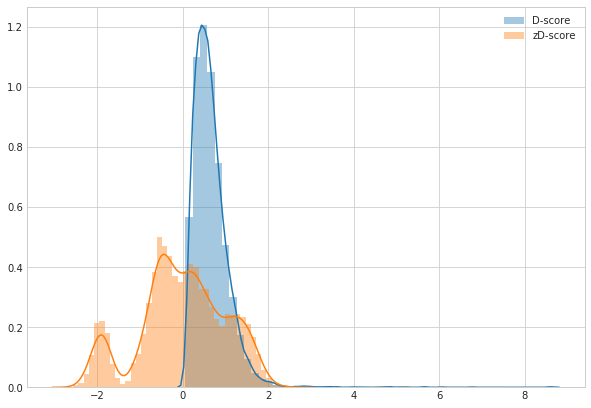

In [295]:
plt.figure(figsize=[10,7])
v = df_res[koi].values
sns.distplot(v[np.isfinite(v)], label='D-score')

v = df_res[koi_mod].values
sns.distplot(v[np.isfinite(v)], label='zD-score')

plt.legend()

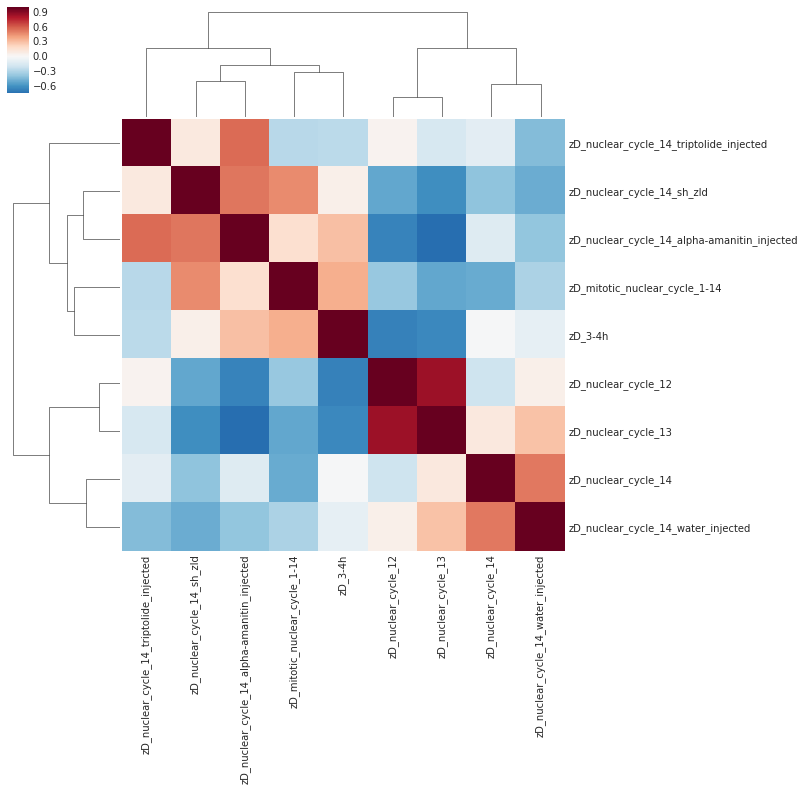

In [296]:
sns.clustermap(df_res.loc[:, koi_mod].corr(), cmap='RdBu_r', center=0)

In [297]:
colors = sns.color_palette('Set1', len(koi_mod))

In [298]:
len(df_res)

979

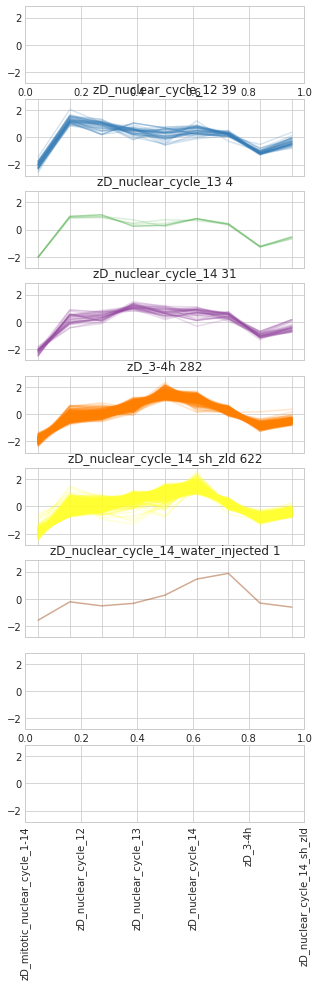

In [299]:
#plt.figure()
fig, axes = plt.subplots(len(koi_mod), 1, sharey=True, figsize=[5,15])

v_pres = {}
for i, r in df_res.iterrows():
    v = np.argmax(r[koi_mod].values)
    color = colors[v]
    if not v in v_pres.keys():
        v_pres[v] = 0
        axes[v].plot(r[koi_mod], label=v, color=color, alpha=0.5)
    else:
        axes[v].plot(r[koi_mod].values, color=color, alpha=0.2)
    v_pres[v] += 1
    
#handles, labels = ax.get_legend_handles_labels()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax[v].legend(handles, labels)

for v in v_pres:
    axes[v].set_xticklabels([])
    axes[v].set_title("{} {}".format(koi_mod[v], v_pres[v]))
    
axes[-1].set_xticklabels(koi_mod, rotation=90)
print('')

In [300]:
nk = 5

In [301]:
centroids, labels = scipy.cluster.vq.kmeans2(df_res[koi_mod], nk, iter=50)

In [302]:
df_res.loc[:, "cluster"] = labels

In [303]:
colors = sns.color_palette('rainbow', nk)
colors1 = [[max(x[0]-0.2, 0), max(x[1]-0.2, 0), max(x[2]-0.2, 0)] for x in colors]

In [304]:
len(labels), len(df_res)

(979, 979)

In [305]:
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=int32)

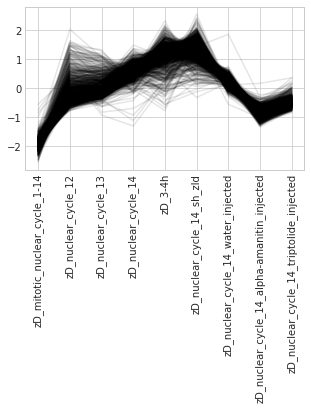

In [324]:
#plt.figure()
fig, axes = plt.subplots(1, 1, sharey=True, figsize=[5,int(15*1/4)])

v_pres = {}
v = 0
for i, r in df_res.iterrows():
    color = colors[v]
    if not v in v_pres.keys():
        v_pres[v] = 0
        axes.plot(r[koi_mod], label=v, color='grey', alpha=0.1)
    else:
        axes.plot(r[koi_mod].values, color='black', alpha=0.1)
    v_pres[v] += 1

axes.set_xticklabels(koi_mod, rotation=90)
print('')

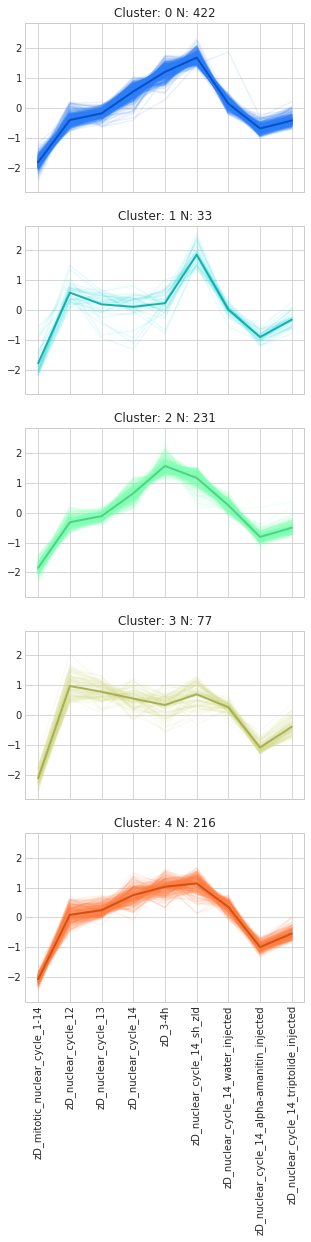

In [306]:
#plt.figure()
fig, axes = plt.subplots(len(centroids), 1, sharey=True, figsize=[5,int(15*nk/4)])

v_pres = {}
for v, (i, r) in zip(labels, df_res.iterrows()):
    color = colors[v]
    if not v in v_pres.keys():
        v_pres[v] = 0
        axes[v].plot(r[koi_mod], label=v, color=color, alpha=0.1)
    else:
        axes[v].plot(r[koi_mod].values, color=color, alpha=0.1)
    v_pres[v] += 1
    
for v, c in enumerate(centroids):
    color = colors1[v]
    axes[v].plot(c, color=color, alpha=0.9, lw=2) #-np.min(df_res[koi_mod])

for v in v_pres:
    axes[v].set_xticklabels([])
    axes[v].set_title("Cluster: {} N: {}".format(v, v_pres[v]))
    
axes[-1].set_xticklabels(koi_mod, rotation=90)
print('')

In [307]:
df_res.groupby("cluster").aggregate({'noisy_region':"sum", "length":"mean", 'ch':'count'})

noisy_region     length   ch
cluster                              
0                15.0  11.274882  422
1                12.0  14.030303   33
2                 4.0  11.324675  231
3                 3.0  13.155844   77
4                 1.0  14.625000  216

In [308]:
len(df_res), len(df_res.query("noisy_region==True"))

(979, 35)

In [309]:
colors2 = ['black' for x in range(nk)]

col1 = 'blue'
col2 = 'lightblue'
col3 = 'green'
col4 = 'yellow'
col5 = 'orange'

colors2[0] = col1

colors2[1] = col2

colors2[2] = col3

colors2[3] = col4

colors2[4] = col5

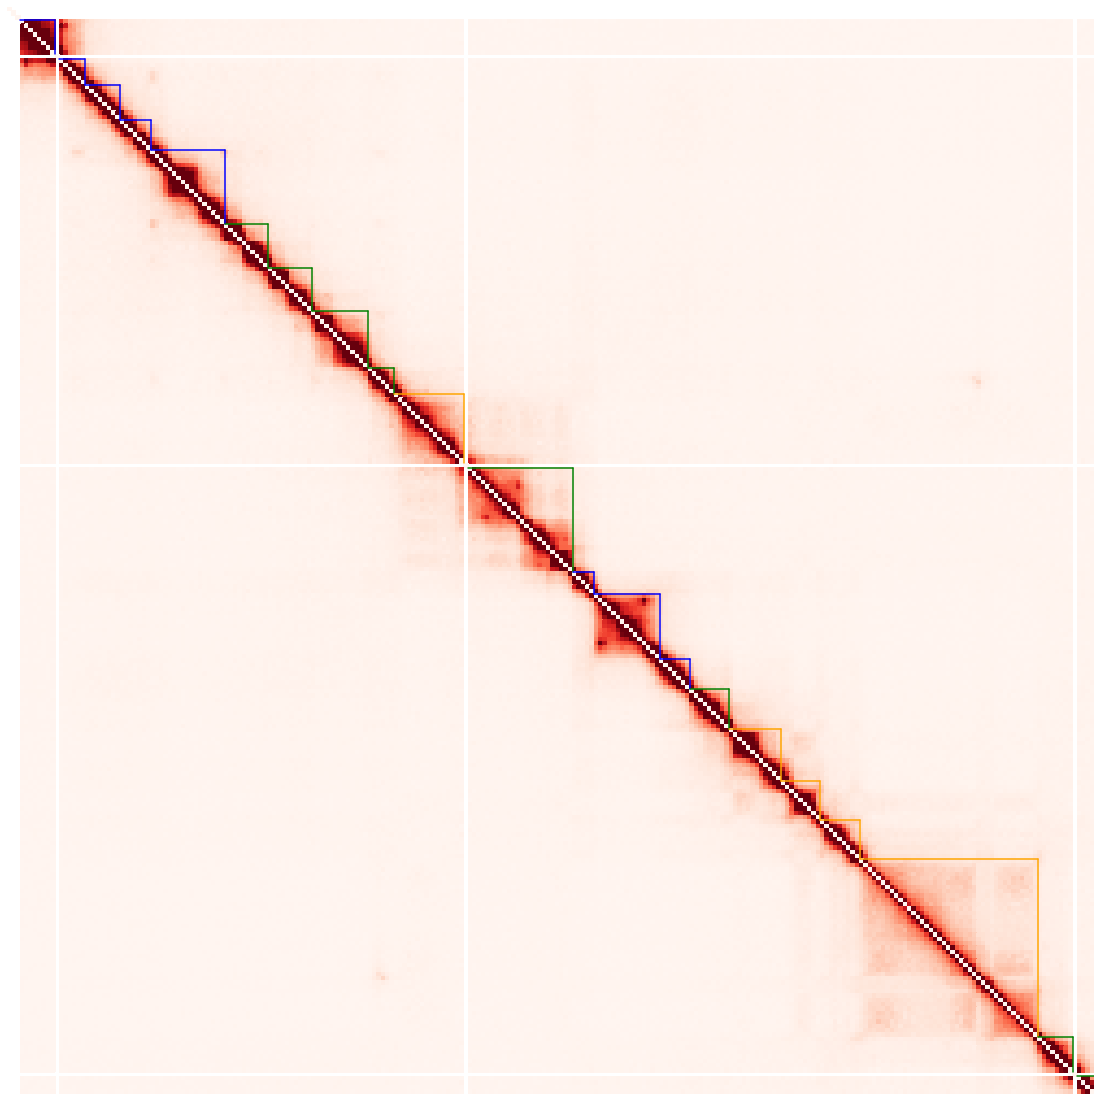

In [310]:
method = method #'modularity' #'armatus' #

ch = '3L'
df_tmp = df_res.query("ch=='{}'".format(ch))
segments = df_tmp[['bgn', 'end']].values

exp = '3-4h'
mtx_cor = datasets[exp][ch]
np.fill_diagonal(mtx_cor, 0)

bgn = 0
end = 250

plt.figure(figsize=[20,20])
sns.heatmap(np.log(mtx_cor[bgn:end, bgn:end]+1), 
            cmap="Reds", 
            square=True, 
            cbar=False, 
            vmax=np.nanpercentile(mtx_cor, 99.9))
plt.xticks([])
plt.yticks([])
print('')

for l, seg in zip(df_tmp['cluster'].values, segments):
    if seg[0]<end and seg[1]>bgn:
        plt.plot([seg[0]-bgn, seg[1]-bgn], [seg[0]-bgn, seg[0]-bgn], color=colors2[l])
        plt.plot([seg[1]-bgn, seg[1]-bgn], [seg[0]-bgn, seg[1]-bgn], color=colors2[l])
        
        #plt.plot([seg[0], seg[0]+1], [seg[0], seg[0]], color='blue')
        #plt.plot([seg[1], seg[1]], [seg[1]-1, seg[1]], color='blue')

In [770]:
datasets.keys()

dict_keys(['nuclear_cycle_13', 'nuclear_cycle_14_sh_zld', 'nuclear_cycle_12', '3-4h', 'mitotic_nuclear_cycle_1-14', 'nuclear_cycle_14_water_injected', 'nuclear_cycle_14', 'nuclear_cycle_14_alpha-amanitin_injected', 'nuclear_cycle_14_triptolide_injected'])

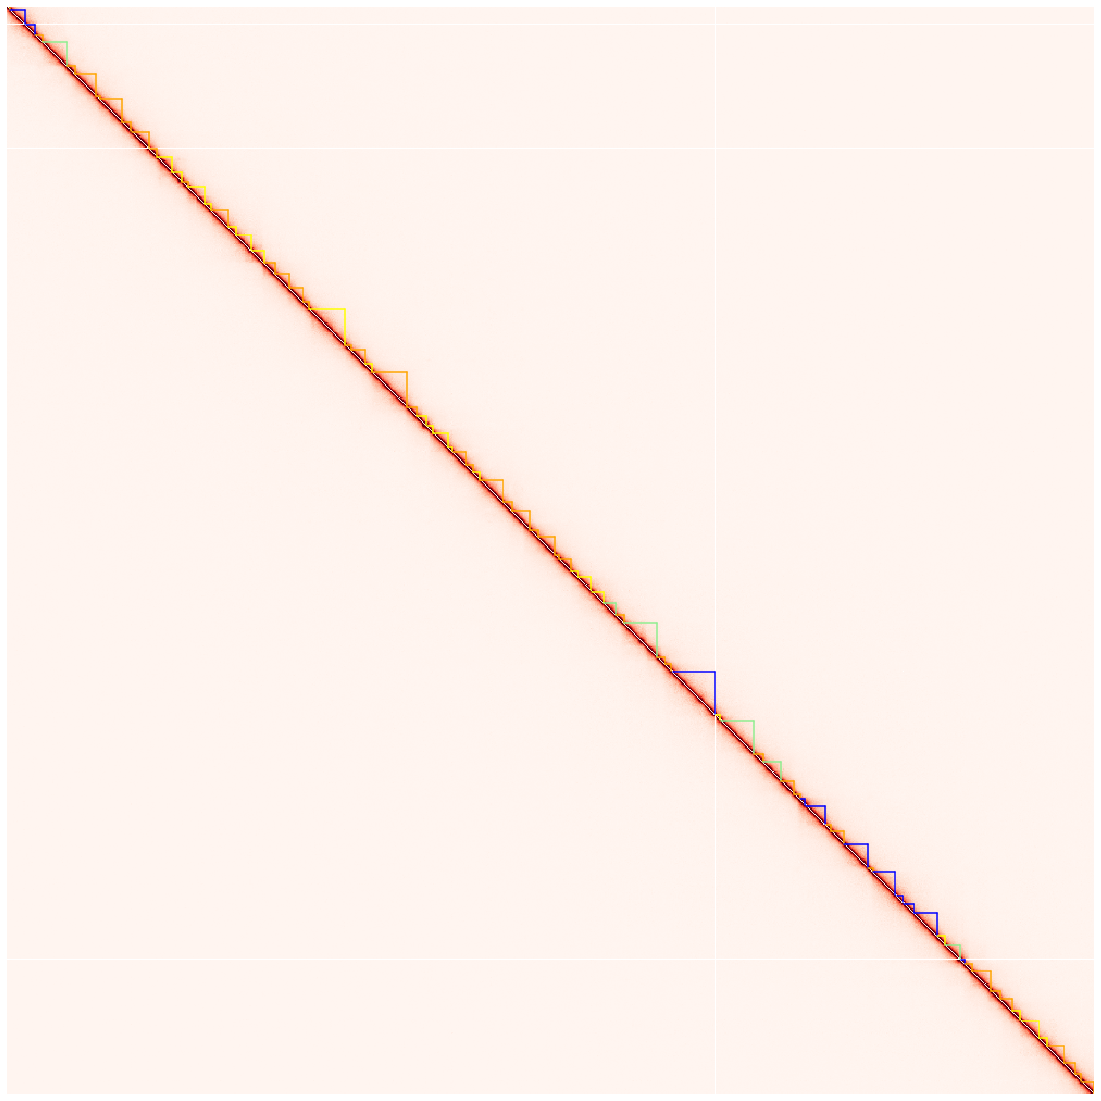

In [156]:
method = method #'modularity' #'armatus' #

ch = '3L'
df_tmp = df_res.query("ch=='{}'".format(ch))
segments = df_tmp[['bgn', 'end']].values

exp = 'nuclear_cycle_12'
mtx_cor = datasets[exp][ch]
np.fill_diagonal(mtx_cor, 0)

bgn = 2000
end = 3000

plt.figure(figsize=[20,20])
sns.heatmap(np.log(mtx_cor[bgn:end, bgn:end]+1), 
            cmap="Reds", 
            square=True, 
            cbar=False, 
            vmax=np.nanpercentile(mtx_cor, 99.9))
plt.xticks([])
plt.yticks([])
print('')

for l, seg in zip(df_tmp['cluster'].values, segments):
    if seg[0]<end and seg[1]>bgn:
        plt.plot([seg[0]-bgn, seg[1]-bgn], [seg[0]-bgn, seg[0]-bgn], color=colors2[l])
        plt.plot([seg[1]-bgn, seg[1]-bgn], [seg[0]-bgn, seg[1]-bgn], color=colors2[l])
        
        #plt.plot([seg[0], seg[0]+1], [seg[0], seg[0]], color='blue')
        #plt.plot([seg[1], seg[1]], [seg[1]-1, seg[1]], color='blue')

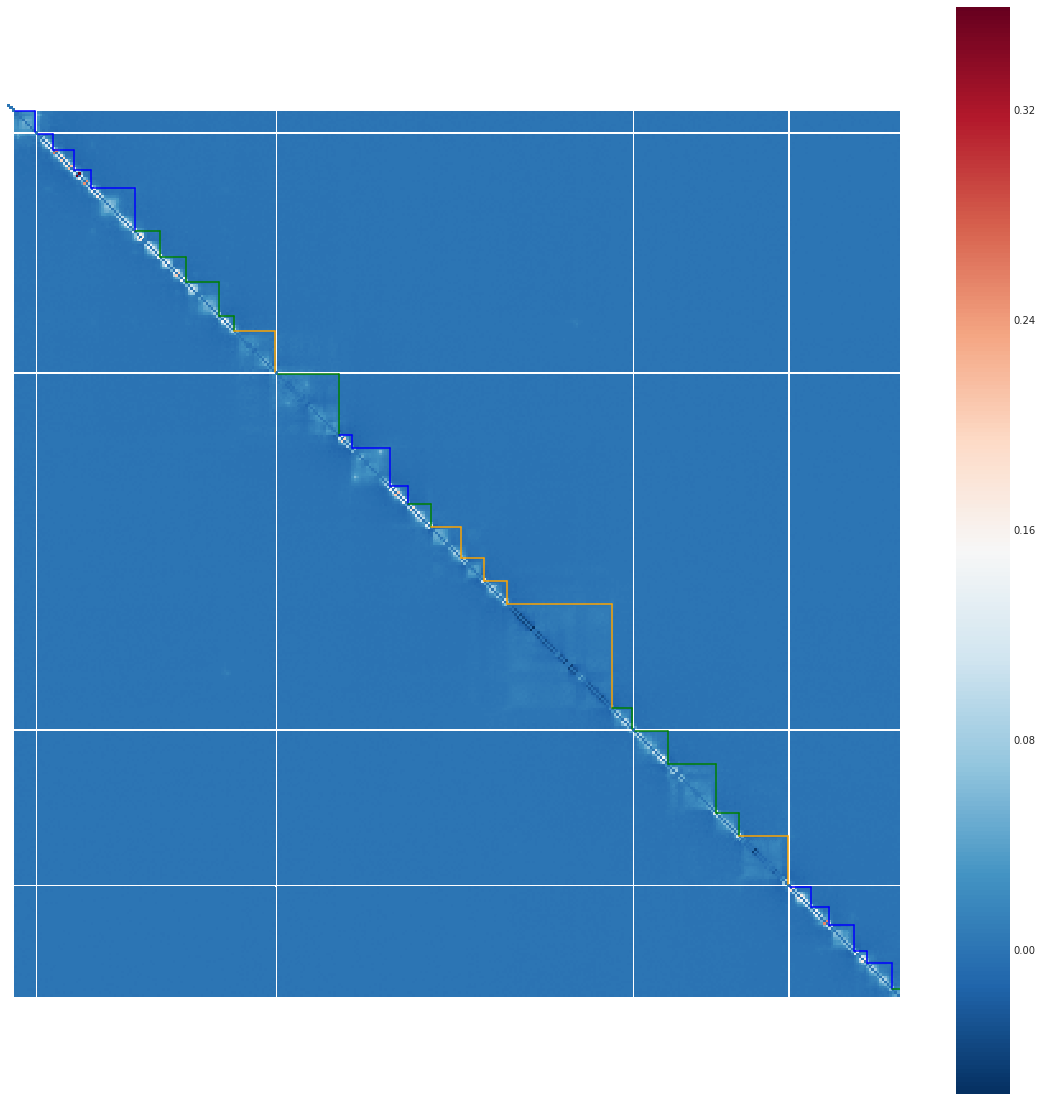

In [312]:
method = method
opt_gamma = 125

ch = '3L'
df_tmp = df_res.query("ch=='{}'".format(ch))
segments = df_tmp[['bgn', 'end']].values

exp1 = '3-4h'
exp2 = 'nuclear_cycle_12'

mtx_cor = datasets[exp1][ch] - datasets[exp2][ch]
np.fill_diagonal(mtx_cor, 0)

end = 350

plt.figure(figsize=[20,20])
sns.heatmap(mtx_cor[0:end, 0:end], 
            cmap="RdBu_r", 
            square=True, 
            cbar=True)
plt.xticks([])
plt.yticks([])
print('')

for l, seg in zip(df_tmp['cluster'].values, segments):
    if seg[0]<end:
        plt.plot([seg[0], seg[1]], [seg[0], seg[0]], color=colors2[l])
        plt.plot([seg[1], seg[1]], [seg[0], seg[1]], color=colors2[l])


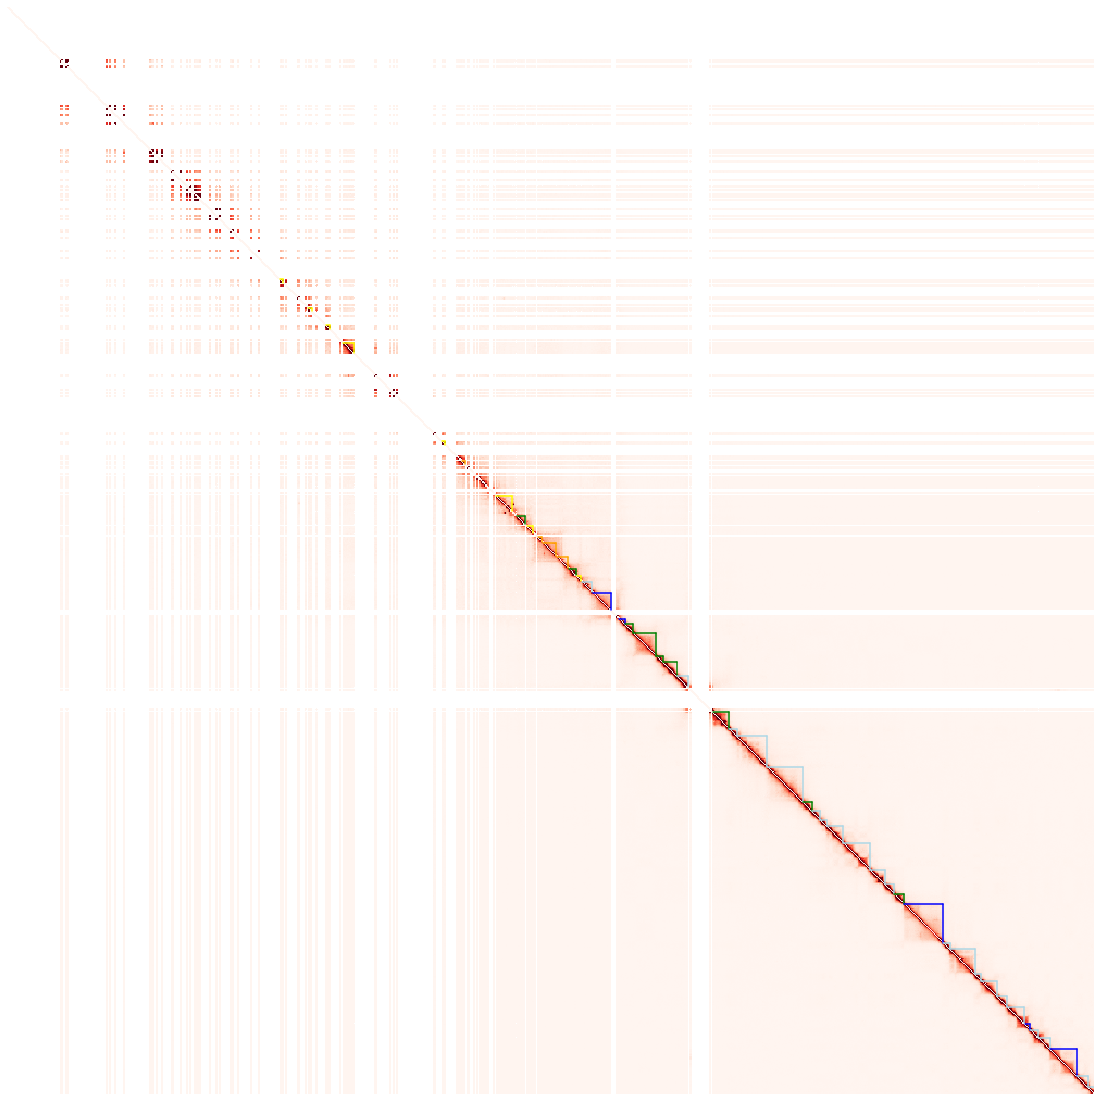

In [235]:
method = method #'modularity' #'armatus' #

ch = '2R'
df_tmp = df_res.query("ch=='{}'".format(ch))
segments = df_tmp[['bgn', 'end']].values

exp = '3-4h'
mtx_cor = datasets[exp][ch]
np.fill_diagonal(mtx_cor, 0)

bgn = 0
end = 1000

plt.figure(figsize=[20,20])
sns.heatmap(np.log(mtx_cor[bgn:end, bgn:end]+1), 
            cmap="Reds", 
            square=True, 
            cbar=False, 
            vmax=np.nanpercentile(mtx_cor, 99.9))
plt.xticks([])
plt.yticks([])
print('')

for l, seg in zip(df_tmp['cluster'].values, segments):
    if seg[0]<end and seg[1]>bgn:
        plt.plot([seg[0]-bgn, seg[1]-bgn], [seg[0]-bgn, seg[0]-bgn], color=colors2[l])
        plt.plot([seg[1]-bgn, seg[1]-bgn], [seg[0]-bgn, seg[1]-bgn], color=colors2[l])
        
        #plt.plot([seg[0], seg[0]+1], [seg[0], seg[0]], color='blue')
        #plt.plot([seg[1], seg[1]], [seg[1]-1, seg[1]], color='blue')

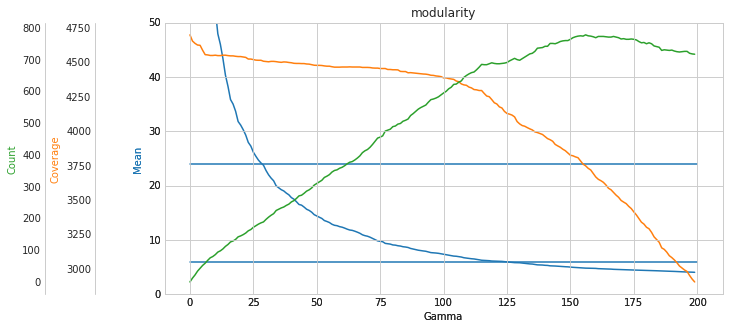

In [176]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

for method in [method]: #,'armatus' ]: # 

    gr_mean = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).mean().reset_index().sort_values(['method', 'gamma'])
    #gr_median = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).median().reset_index().sort_values(['method', 'gamma'])
    gr_count = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).count().reset_index().sort_values(['method', 'gamma'])
    gr_cov = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).sum().reset_index().sort_values(['method', 'gamma'])


    plt.figure(figsize=[10,5])
    host = host_subplot(111, axes_class=AA.Axes)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 70
    new_fixed_axis = par1.get_grid_helper().new_fixed_axis
    par1.axis["left"] = new_fixed_axis(loc="left",
                                        axes=par1,
                                        offset=(-offset, 0))


    offset = 120
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["left"] = new_fixed_axis(loc="left",
                                        axes=par2,
                                        offset=(-offset, 0))

    host.set_xlabel("Gamma")
    host.set_ylabel("Mean")
    par1.set_ylabel("Coverage")
    par2.set_ylabel("Count")

    p1, = host.plot(gr_mean.gamma,   gr_mean.length, label="{} mean".format(method))
    p1, = host.plot([0,200], [expected, expected], color=p1.get_color())
    p1, = host.plot([0,200], [6, 6], color=p1.get_color())
    p2, = par1.plot(gr_cov.gamma, gr_cov.length, label="{} coverage".format(method))
    p3, = par2.plot(gr_count.gamma,  gr_count.length,  label="{} count".format(method))

    host.set_ylim([0,50])
    
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["left"].label.set_color(p2.get_color())
    par2.axis["left"].label.set_color(p3.get_color())

    plt.title(method)

In [87]:
expected = 120000/resolution

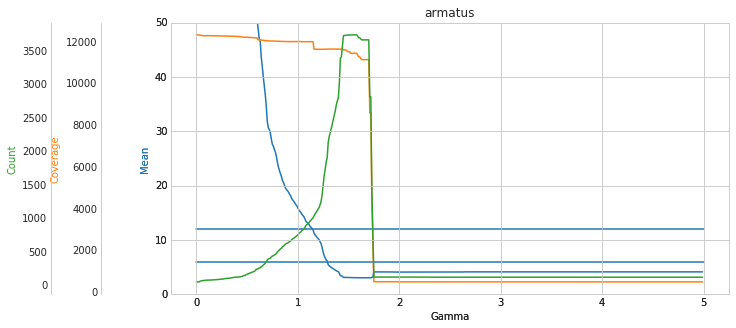

In [200]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

for method in [ 'armatus']: #,'armatus' ]: # 

    gr_mean = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).mean().reset_index().sort_values(['method', 'gamma'])
    #gr_median = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).median().reset_index().sort_values(['method', 'gamma'])
    gr_count = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).count().reset_index().sort_values(['method', 'gamma'])
    gr_cov = df.query('method=="{}"'.format(method)).groupby(['gamma', 'method']).sum().reset_index().sort_values(['method', 'gamma'])


    plt.figure(figsize=[10,5])
    host = host_subplot(111, axes_class=AA.Axes)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 70
    new_fixed_axis = par1.get_grid_helper().new_fixed_axis
    par1.axis["left"] = new_fixed_axis(loc="left",
                                        axes=par1,
                                        offset=(-offset, 0))


    offset = 120
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["left"] = new_fixed_axis(loc="left",
                                        axes=par2,
                                        offset=(-offset, 0))

    host.set_xlabel("Gamma")
    host.set_ylabel("Mean")
    par1.set_ylabel("Coverage")
    par2.set_ylabel("Count")

    p1, = host.plot(gr_mean.gamma,   gr_mean.length, label="{} mean".format(method))
    p1, = host.plot([0,5], [expected, expected], color=p1.get_color())
    p1, = host.plot([0,5], [6, 6], color=p1.get_color())
    p2, = par1.plot(gr_cov.gamma, gr_cov.length, label="{} coverage".format(method))
    p3, = par2.plot(gr_count.gamma,  gr_count.length,  label="{} count".format(method))

    host.set_ylim([0,50])
    
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["left"].label.set_color(p2.get_color())
    par2.axis["left"].label.set_color(p3.get_color())

    plt.title(method)

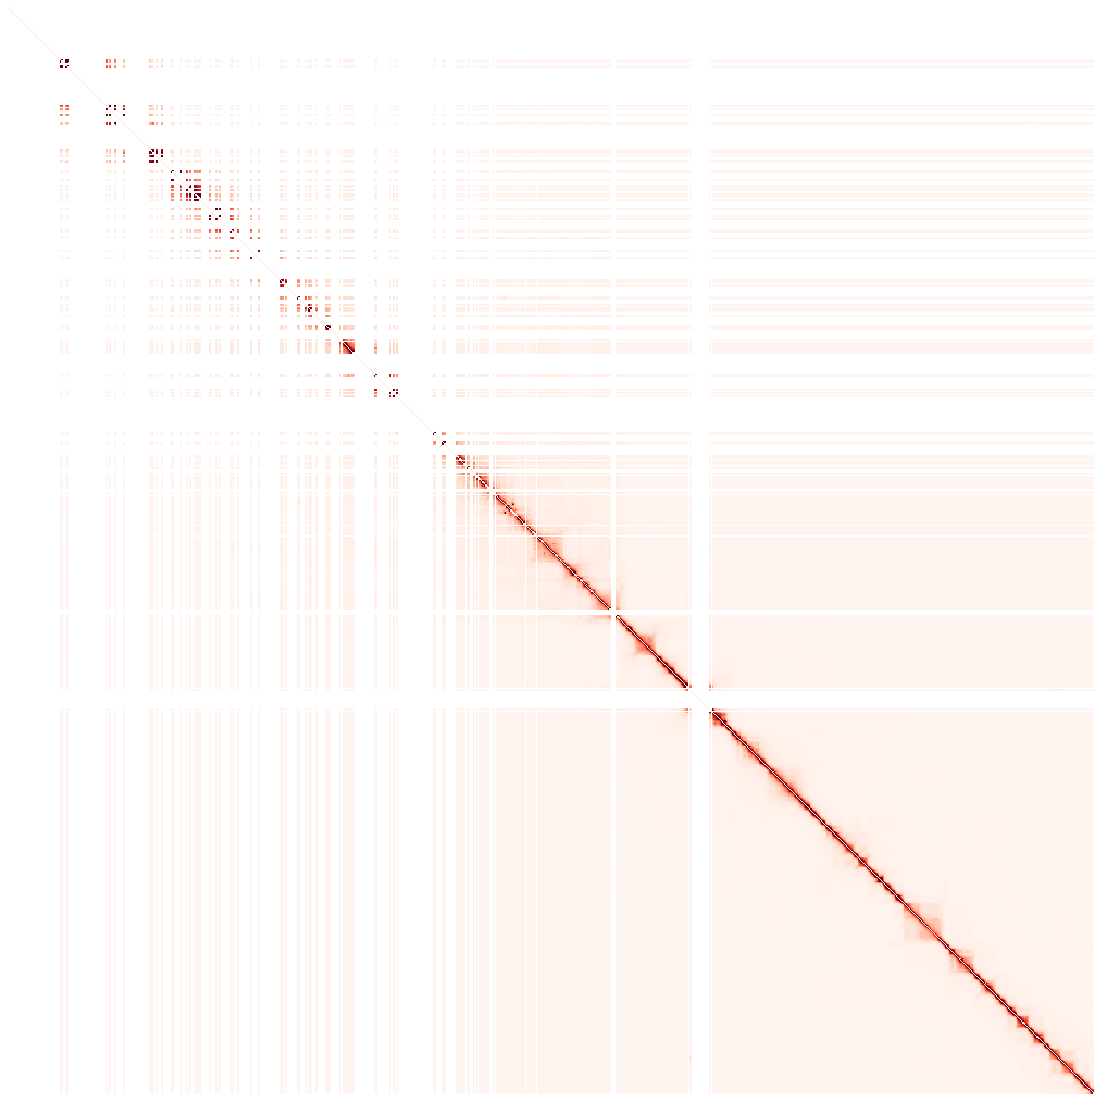

In [52]:
exp = '3-4h'
ch = '2R'
mtx_cor = datasets[exp][ch].copy()
np.fill_diagonal(mtx_cor, 0)

end = 1000

plt.figure(figsize=[20,20])
sns.heatmap(np.log(mtx_cor[0:end, 0:end]+1), 
            cmap="Reds", 
            square=True, 
            cbar=False, 
            vmax=np.nanpercentile(mtx_cor, 99.9))
plt.xticks([])
plt.yticks([])
print('')

In [36]:
np.nanmean(mtx_cor)

7.785801542546238